In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as st
import seaborn as sns

from statsmodels.distributions.empirical_distribution import ECDF

matplotlib.style.use('ggplot')

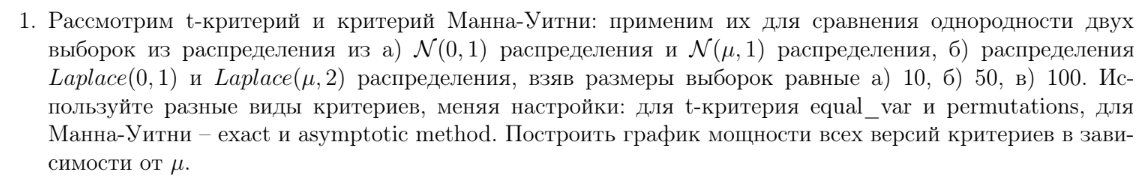

In [5]:
def power_plot(dist1, dist2):
    N = [10, 50, 100]

    P = np.linspace(0, 0.4, 40)

    plt.subplots_adjust(right=2, left=0.05)

    for j in range(1, 4):
        n = N[j-1]
        mann_exact = []
        mann_as = []
        ttest = []
        ttest_perm = []

        for p in P:
            mann_count = 0
            mann_as_count = 0
            ttest_count = 0
            ttest_perm_count = 0

            for i in range(100):
                sample1 = dist1(0, 1).rvs(size=n)
                sample2 = dist2(p, 1).rvs(size=n)

                mann_val = st.mannwhitneyu(sample1, sample2, method='exact', alternative='two-sided').pvalue
                if (mann_val < 0.05):
                    mann_count += 1

                mman_val = st.mannwhitneyu(sample1, sample2, method='asymptotic', alternative='two-sided').pvalue
                if (mann_val < 0.05):
                    mann_as_count += 1

                t_val = st.ttest_ind(sample1, sample2, equal_var=True, alternative='two-sided').pvalue
                if(t_val < 0.05):
                    ttest_count += 1

                t_val = st.ttest_ind(sample1, sample2, equal_var=True, permutations=100, alternative='two-sided').pvalue
                if(t_val < 0.05):
                    ttest_perm_count += 1

            mann_exact.append(mann_count/100)
            mann_as.append(mann_as_count/100)
            ttest.append(ttest_count/100)
            ttest_perm.append(ttest_perm_count/100)

        plt.subplot(1, 3, j)
        plt.plot(P, np.sort(mann_exact), label='m exact '+str(n))
        plt.plot(P, np.sort(mann_as), label=' m asymptotic '+str(n))
        plt.plot(P, np.sort(ttest), label='t '+str(n))
        plt.plot(P, np.sort(ttest_perm), label='t_perm '+str(n))
        plt.legend()

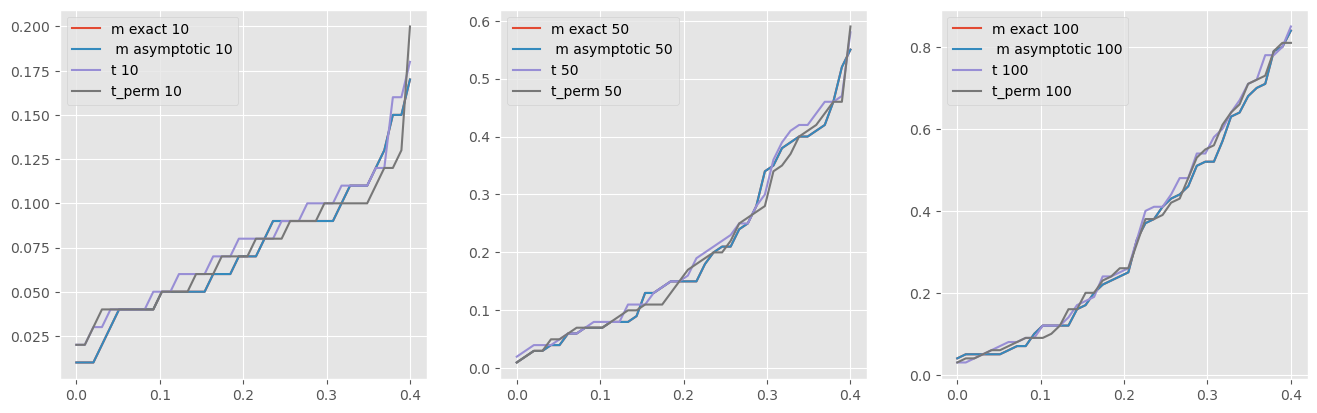

In [11]:
power_plot(st.norm, st.norm)

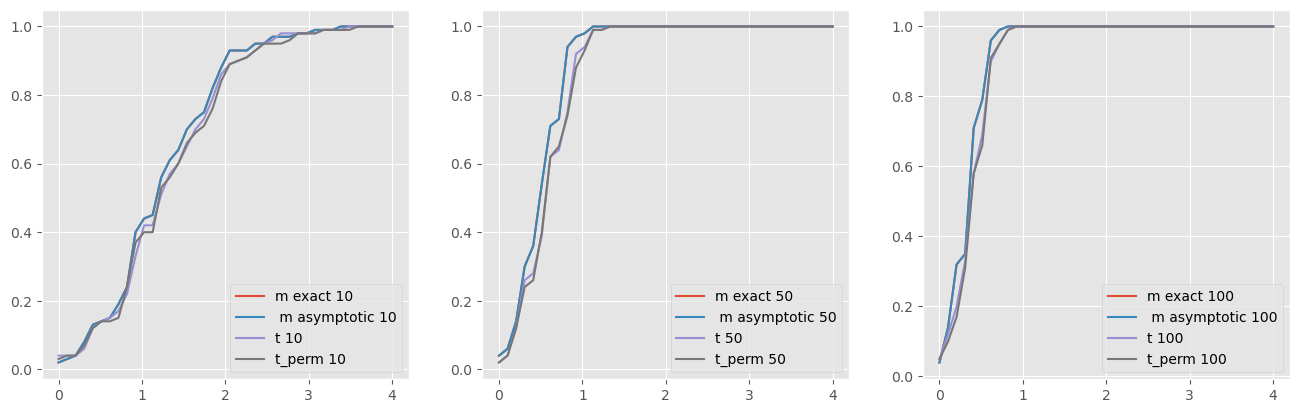

In [18]:
power_plot(st.laplace, st.laplace)

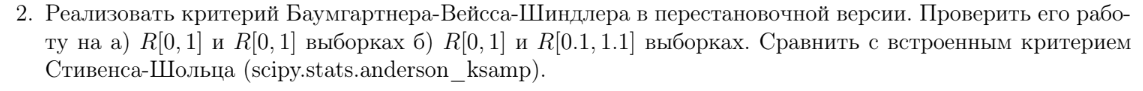

In [38]:
def baumgartner_value(sample1, sample2, n1, n2):
    #массивы рангов
    unit_rank = st.rankdata(np.concatenate((sample1, sample2)))
    rank1 = np.sort(unit_rank[0:n1])
    rank2 = np.sort(unit_rank[n1:n1+n2])
    
    ans = 0
    ans += b_sum(n1, n2, rank1)
    ans += b_sum(n2, n1, rank2)
    
    return ans

def b_sum(n1, n2, rank1):
    ans = 0
    tmp = 0
    for i in range(n1):
        tmp = (rank1[i] - (n1 + n2)*(i + 1)/n1)**2
        tmp /= ((i+1)/(n1+1))
        tmp /= (1 - (i+1)/(n1+1))
        tmp /= (n2*(n1+n2)/n1)
        ans += tmp
        
    ans /= (2*n1)
    return ans
        

def counter(val):
    f = open('quantiles/anderson_darling.txt', 'r')
    data = f.read()
    data = data.split(" ")
    count = 0
    while float(data[count]) <= val:
        count += 1
        if count >= len(data)-1:
            break
    count /= len(data)
    return count

In [40]:
#генерация квантилей!
f = open('quantiles/anderson_darling.txt', 'w')

table = []
for i in range(1000):
    sample1 = sc.stats.norm.rvs(0, 1, size=300)
    sample2 = sc.stats.norm.rvs(0, 1, size=300)
    val = baumgartner_value(sample1, sample2, 300, 300)
    table.append(val)
    
table = np.array(table)
table = np.sort(table)

for i in range(len(table)):
    f.write(str(table[i]) + ' ')
    
f.close()

In [48]:
#Сравнение осуществим засчет графика мощности в зависимости от размеров выборки
def power(dist1, dist2, n):
    P = np.linspace(int(n/4), 4*int(n/4), 20)
    baumgartner = []
    ksamp = []
    for p in P:
        baum_count = 0
        ksamp_count = 0
        for i in range(300):
            sample1 = dist1.rvs(size=int(p))
            sample2 = dist2.rvs(size=int(p))
            if 1 - counter(baumgartner_value(sample1, sample2, int(p), int(p))) < 0.05:
                baum_count += 1
            if st.ks_2samp(sample1, sample2).pvalue < 0.05:
                ksamp_count += 1
            
        baumgartner.append(baum_count/300)
        ksamp.append(ksamp_count/300)
    plt.plot(P, baumgartner, label='b')
    plt.plot(P, ksamp, label='k')
    plt.legend()

def pval(dist1, dist2, n):
    baumgartner = []
    ksamp = []
    for i in range(300):
        sample1 = dist1.rvs(size=n)
        sample2 = dist2.rvs(size=n)
        baumgartner.append(1 - counter(baumgartner_value(sample1, sample2, n, n)))
        
        rng = np.random.default_rng()
        m = st.PermutationMethod(n_resamples=200, random_state=rng)
        ksamp.append(st.anderson_ksamp([sample1, sample2], midrank=True, method=m).pvalue)
    
    t = np.linspace(0, 1, 300)
    plt.plot(np.sort(baumgartner), t, label='b')
    plt.plot(np.sort(ksamp), t, label='k')
    plt.legend() 

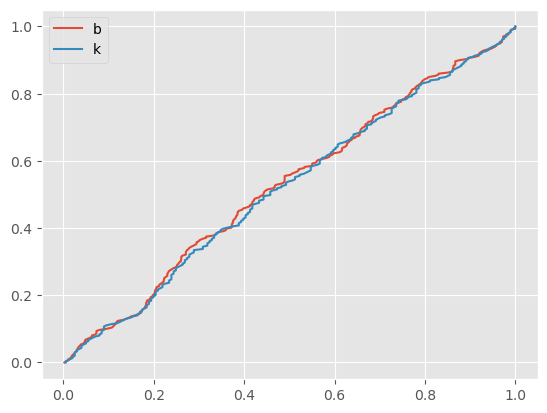

In [52]:
pval(st.uniform(0, 1), st.uniform(0, 1), 100)

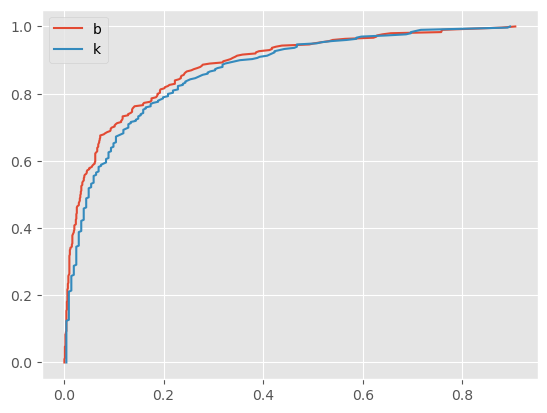

In [54]:
pval(st.uniform(0.1, 1.1), st.uniform(0, 1), 30)

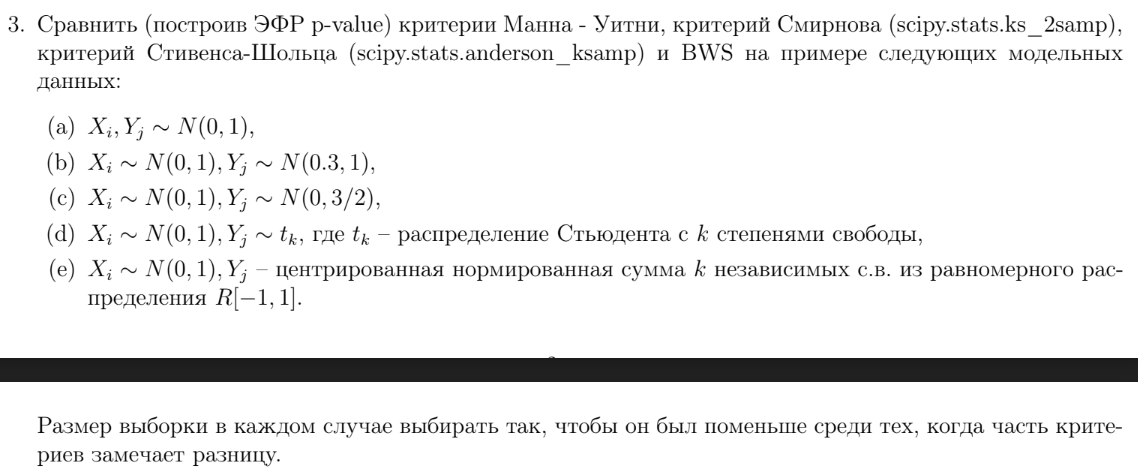

In [92]:
def pval_plot(dist1, dist2, n1, n2):
    mann = []
    tsamp = []
    ksamp = []
    bws = []
    
    for i in range(300):
        sample1 = dist1.rvs(size=n1)
        sample2 = dist2.rvs(size=n2)
                
        mann.append(st.mannwhitneyu(sample1, sample2, method='asymptotic', alternative='two-sided').pvalue)
        
        rng = np.random.default_rng()
        m = st.PermutationMethod(n_resamples=200, random_state=rng)
        ksamp.append(st.anderson_ksamp([sample1, sample2], midrank=True, method=m).pvalue)
        tsamp.append(st.ks_2samp(sample1, sample2).pvalue)
        bws.append(1 - counter(baumgartner_value(sample1, sample2, n1, n2)))
    
    t = np.linspace(0, 1, 300)
    plt.plot(np.sort(mann), t, label='mann')
    plt.plot(np.sort(tsamp), t, label='2samp')
    plt.plot(np.sort(ksamp), t, label='ksamp')
    plt.plot(np.sort(bws), t, label='bws')
    
    plt.legend()

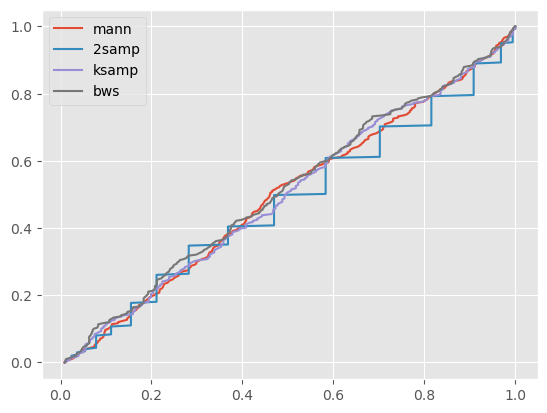

In [86]:
#a)
pval_plot(st.norm(0, 1), st.norm(0, 1), 100, 100)

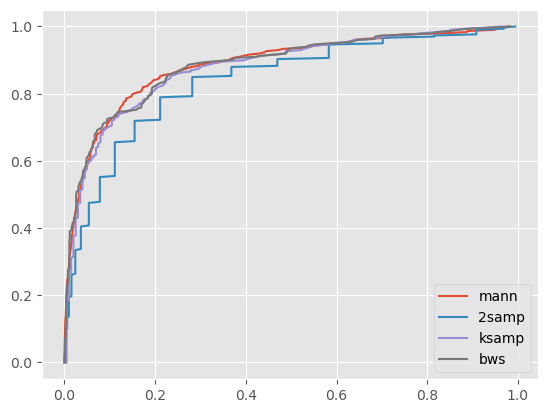

In [88]:
#b)
pval_plot(st.norm(0, 1), st.norm(0.3, 1), 100, 100)

Кол-во степеней свободы:  4


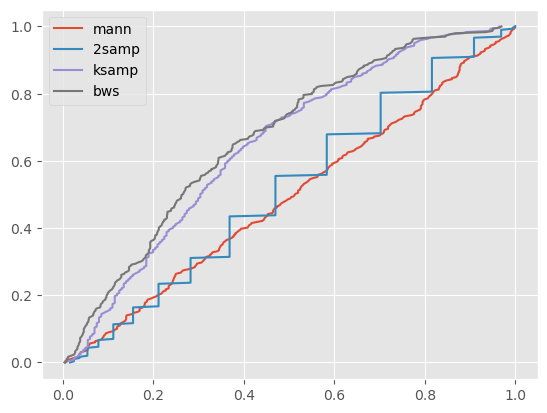

In [90]:
#c)
k = int(input("Кол-во степеней свободы: "))
pval_plot(st.norm(0, 1), st.t(df=k), 100, 100)

Кол-во слагаемых:  10


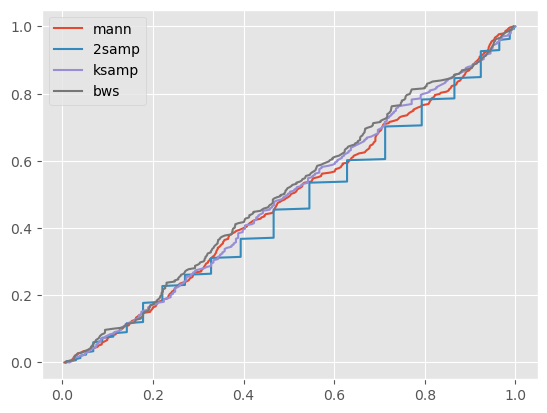

In [103]:
#d)
n1 = 200
n2 = 200
k = int(input("Кол-во слагаемых: "))

mann = []
tsamp = []
ksamp = []
bws = []
    
for i in range(300):
    sample1 = st.norm(0,1).rvs(size=n1)
    sample2 = []
    for j in range(n2):
        tmp = st.uniform(-1, 2).rvs(size=k)
        sample2.append(np.sum(tmp)/np.sqrt(k/3))
        
    sample2 = np.array(sample2)
        
    mann.append(st.mannwhitneyu(sample1, sample2, method='asymptotic', alternative='two-sided').pvalue)

    rng = np.random.default_rng()
    m = st.PermutationMethod(n_resamples=200, random_state=rng)
    ksamp.append(st.anderson_ksamp([sample1, sample2], midrank=True, method=m).pvalue)
    tsamp.append(st.ks_2samp(sample1, sample2).pvalue)
    bws.append(1 - counter(baumgartner_value(sample1, sample2, n1, n2)))

t = np.linspace(0, 1, 300)
plt.plot(np.sort(mann), t, label='mann')
plt.plot(np.sort(tsamp), t, label='2samp')
plt.plot(np.sort(ksamp), t, label='ksamp')
plt.plot(np.sort(bws), t, label='bws')

plt.legend()

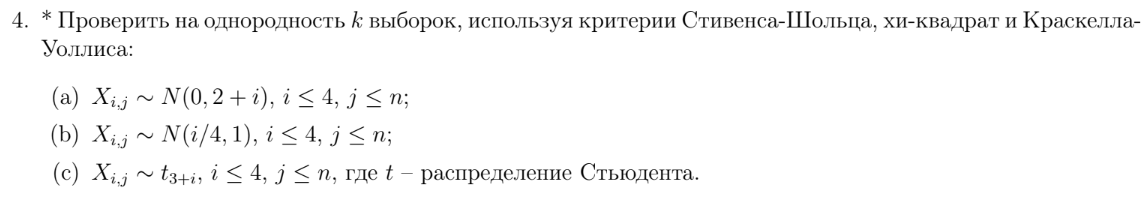

In [15]:
def chi2_pval(data, sizes, m):
    k = round(n**0.2) #кол-во ячеек, считаем, что k делит sizes[i]
    for i in range(m):
        sizes[i] = int(sizes[i]/k)*k
        data[i] = data[i][:sizes[i]]

    sample = np.concatenate(data)
    sample = np.sort(sample)
    quant = [] #считаем, что помимо этого у нас есть -inft и +inft
    for i in range(1, k):
        quant.append(sample[int(i*np.sum(sizes)/k)])

    freq = []
    for i in range(m):
        curr_freq = np.zeros(k)
        sample = data[i]
        for elem in sample:
            for j in range(k-1):
                if j == 0:
                    if elem <= quant[j]:
                        curr_freq[j] += 1
                        break
                else:
                    if quant[j-1] < elem <= quant[j]:
                        curr_freq[j] += 1
                        break
                if j == k-2:
                    curr_freq[k-1] += 1
        freq.append(curr_freq)

    #статистика Пирсона
    stat = 0
    for j in range(k):
        sum_freq = 0
        for i in range(m):
            sum_freq += freq[i][j]

        for i in range(m):
            tmp = (freq[i][j] - (sizes[i]/np.sum(sizes) * sum_freq))**2
            tmp /= (sizes[i]/np.sum(sizes) * sum_freq)
            stat += tmp
            
    return 1-st.chi2.cdf(stat, df=(m-1)*(k-1))
        

In [13]:
#dist, sizes - массивы размера k, где k - кол-во выборок
def plot_pval(dist, sizes, k):
    ksamp = []
    chi = []
    kruskal = []
    for i in range(300):
        data = [dist[j].rvs(size=sizes[j]) for j in range(k)]
        
        rng = np.random.default_rng()
        m = st.PermutationMethod(n_resamples=200, random_state=rng)
        ksamp.append(st.anderson_ksamp(data, midrank=True, method=m).pvalue)
        
        kruskal.append(st.kruskal(data[0], data[1], data[2], data[3], data[4]).pvalue)
        
        #Хи-квадрат
        chi.append(chi2_pval(data, sizes, k))
    
    t = np.linspace(0, 1, 300)
    plt.plot(np.sort(ksamp), t, label='ksamp')
    plt.plot(np.sort(kruskal), t, label='kr')
    plt.plot(np.sort(chi), t, label='chi')
    
    plt.legend()

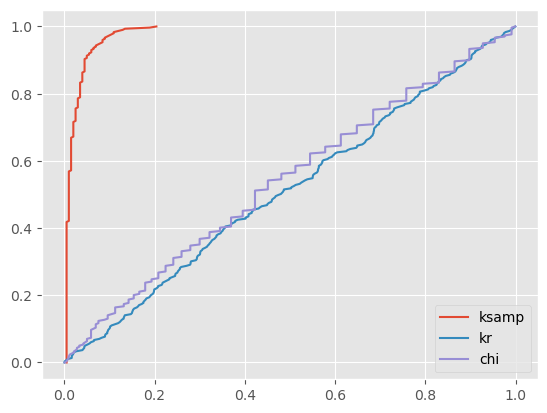

In [17]:
#a)
n = 40
dist = [st.norm(0, 2+i) for i in range(0, 5)]
sizes = [n for i in range(0, 5)]
plot_pval(dist, sizes, 5)

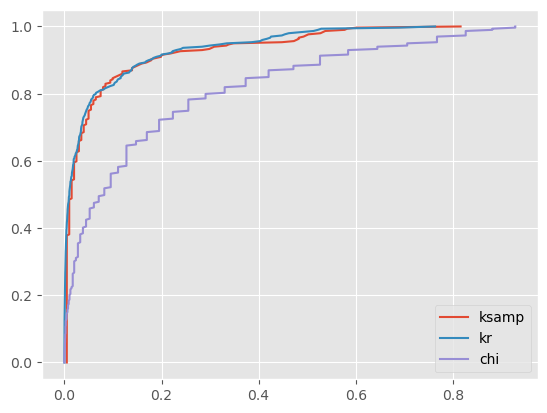

In [12]:
#b)
n = 20
dist = [st.norm(i/4, 1) for i in range(5)]
sizes = [n for i in range(5)]
plot_pval(dist, sizes, 5)

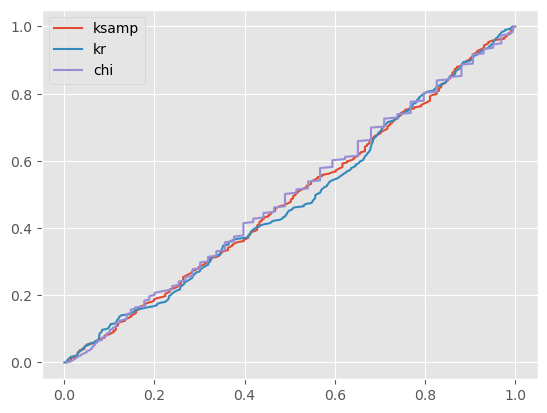

In [23]:
#с)
n = 50
dist = [st.t(df = 3 + i) for i in range(5)]
sizes = [n for i in range(5)]
plot_pval(dist, sizes, 5)

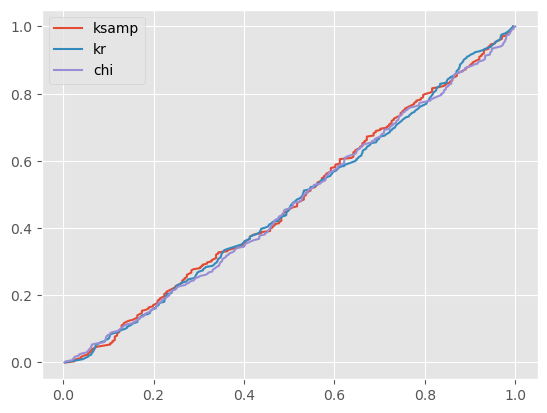

In [19]:
#с)
n = 100
dist = [st.t(df = 3) for i in range(5)]
sizes = [n for i in range(5)]
plot_pval(dist, sizes, 5)